In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

# Objectif du notebook

Comparer les différentes modélisation possible sur la variable **production Hydraulique** :

* SARIMAX avec des données métier en régresseurs exogènes
* SARIMAX sur le signal sans régresseur
* Régression linéaire sur les données métiers comme variables explicatives

**NOTA BENE :** Pour la période 3h, le calcul avec un modèle SARIMAX n'aboutit pas sans données exogènes en paramètre.

# Import du dataset original

In [2]:
df = pd.read_csv('./dataset/France_W.csv',
                usecols = ['Dates', 'Hydraulique'])
df.head(1)

,Dates,Hydraulique
0,2013-01-06,8026.586111


In [3]:
df['Dates'] = pd.to_datetime(df['Dates'], yearfirst = True)
df.set_index('Dates', inplace = True)

In [4]:
debut = dt.datetime(year = 2013, month = 1, day = 1)
fin = dt.datetime(year = 2020, month = 1, day = 1)

# Conversion en taux de charge pour annuler l'évolution dans le temps

In [5]:
capa = pd.read_csv('./datasource/capacite_hydraulique_FR.csv',
                  usecols = ['Dates', 'Capa_hyd'])
capa['Dates'] = pd.to_datetime(capa['Dates'], format = '%Y/%m/%d %H:%M:%S', yearfirst = True)
capa.set_index('Dates', inplace = True)

In [6]:
capa = capa.resample('W').mean()

In [7]:
df = pd.concat([df, capa], axis = 1)
df['TCH_hyd'] = df['Hydraulique'] / df['Capa_hyd']
df

,Hydraulique,Capa_hyd,TCH_hyd
Dates,,,
2013-01-06,8026.586111,25346,0.316681
2013-01-13,9010.035714,25346,0.355482
2013-01-20,9950.440476,25346,0.392584
2013-01-27,9495.895833,25346,0.374651
2013-02-03,9219.333333,25346,0.363739
...,...,...,...
2021-10-03,3903.928571,25346,0.154025
2021-10-10,5475.130952,25346,0.216016
2021-10-17,3539.616071,25346,0.139652


''

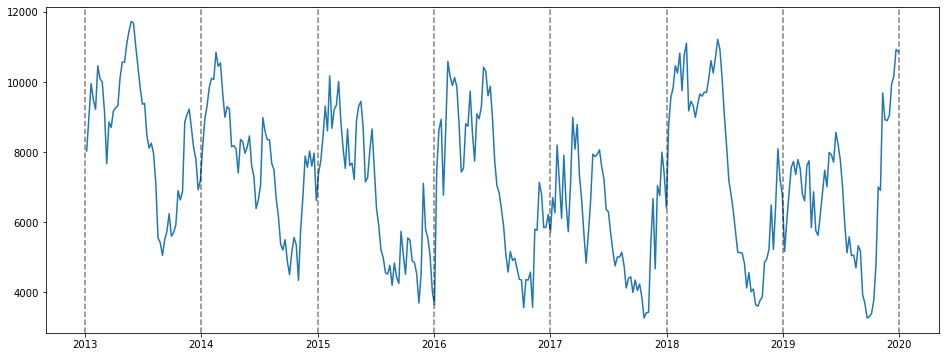

In [8]:
plt.figure(figsize=(16, 6))
plt.plot(df['Hydraulique'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

''

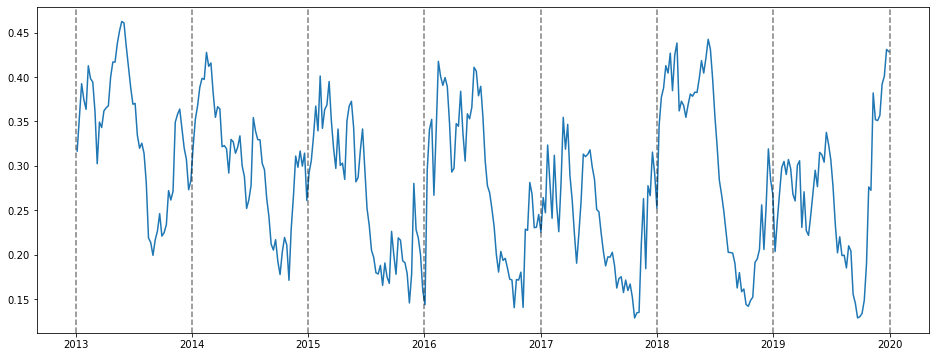

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(df['TCH_hyd'][(df.index >= debut) & (df.index < fin)])
for year in range(debut.year, fin.year + 1): 
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)
;

### Test de stationnarité

In [10]:
# la 2ème valeur donne la p_value (stationnaire si < 5%)
sm.tsa.stattools.adfuller(df['TCH_hyd'])

(-4.521892619859839,
 0.00017948407257816097,
 0,
 460,
 {'1%': -3.44464601455782,
  '5%': -2.867843681679954,
  '10%': -2.570127622873346},
 -1734.2039618288436)

### Coéfficients SARIMAX et saisonnalités

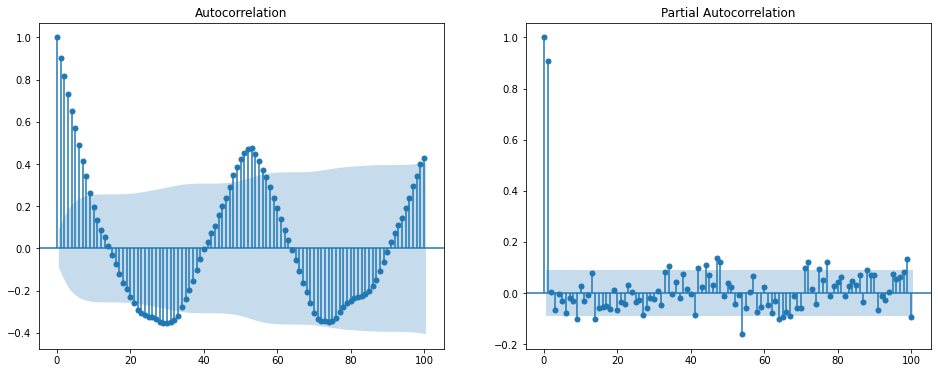

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
plot_acf(df['TCH_hyd'], lags = 100, ax=ax1)
plot_pacf(df['TCH_hyd'], lags = 100, ax=ax2)
plt.show()

**Saisonnalités :**
* 1 an

# Jeux d'entrainement et de test

In [12]:
df_train = df[(df.index >= debut) & (df.index < fin)]
df_test = df[df.index >= fin]

In [13]:
fenetre = df_test.shape[0]

In [14]:
indice = df_test.index

In [15]:
bilan = df_test

# Paramètres SARIMAX

In [16]:
ordre = (2,0,0)
saison = (1,0,0,52)

# Régresseurs exogènes : données métier

In [17]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-06,0.372036


In [18]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [19]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

### SARIMAX

In [20]:
model_exog = sm.tsa.SARIMAX(df_train['TCH_hyd'].values,
                       exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [21]:
result_exog = model_exog.fit(low_memory=True)

In [22]:
result_exog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 52)   Log Likelihood                 727.154
Date:                            Wed, 04 May 2022   AIC                          -1444.308
Time:                                    10:32:27   BIC                          -1424.808
Sample:                                         0   HQIC                         -1436.558
                                            - 365                                         
Covariance Type:                           approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0051      0.002      2.456      0.014       0.001       0.009
ar.L1          0.9400      0.054     17.481      0.000       0.835       1.045
ar.L2          0.0543      0.054      1.009      0.313      -0.051       0.160
ar.S.L52       0.0860      0.057      1.519      0.129      -0.025       0.197
sigma2         0.0011   7.96e-05     13.502      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                51.99
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                             0.66
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [23]:
predict_exog = result_exog.predict(start = 1 ,
                               end = fenetre,
                               exog = exog_test.values)

In [24]:
predict_exog = pd.DataFrame(predict_exog, index = indice, columns = ['Hyd_p_exog'])

In [25]:
bilan = pd.concat([bilan, predict_exog], axis = 1)

### Erreur absolue

In [26]:
bilan['Err_exog'] = np.abs(bilan['Hyd_p_exog'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_exog,Err_exog
count,96.000000,96.0,96.000000,96.000000,96.000000
mean,7269.866474,25346.0,0.286825,0.320882,0.054138
std,1918.504379,0.0,0.075693,0.070158,0.035350
min,3512.699405,25346.0,0.138590,0.180142,0.001172
25%,5738.643601,25346.0,0.226412,0.271489,0.029913
50%,7344.013393,25346.0,0.289750,0.324780,0.045746
75%,8638.646577,25346.0,0.340829,0.367846,0.073483
max,12198.494048,25346.0,0.481279,0.461276,0.150703


# Sans régresseur

### SARIMAX

In [27]:
model_noreg = sm.tsa.SARIMAX(df_train['TCH_hyd'].values,
                       # exog = exog_train.values,
                       # mle_regression = False, # Default = True
                       # simple_differencing = True, #Default = False
                       # state_regression = False,
                       order = ordre,
                       seasonal_order = saison)

In [28]:
result_noreg = model_noreg.fit(low_memory=True)

In [29]:
result_noreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 52)   Log Likelihood                 724.135
Date:                            Wed, 04 May 2022   AIC                          -1440.269
Time:                                    10:32:31   BIC                          -1424.670
Sample:                                         0   HQIC                         -1434.070
                                            - 365                                         
Covariance Type:                           approx                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9419      0.054     17.572      0.000       0.837       1.047
ar.L2          0.0530      0.054      0.989      0.323      -0.052       0.158
ar.S.L52       0.0922      0.056      1.634      0.102      -0.018       0.203
sigma2         0.0011   8.08e-05     13.506      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                50.90
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.64
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [30]:
predict_noreg = result_noreg.predict(start = 1 ,
                               end = fenetre,
                               # exog = exog_test.values
                            )

In [31]:
predict_noreg = pd.DataFrame(predict_noreg, index = indice, columns = ['Hyd_p_noreg'])

In [32]:
bilan = pd.concat([bilan, predict_noreg], axis = 1)

### Erreur absolue

In [33]:
bilan['Err_noreg'] = np.abs(bilan['Hyd_p_noreg'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_exog,Err_exog,Hyd_p_noreg,Err_noreg
count,96.000000,96.0,96.000000,96.000000,96.000000,96.000000,96.000000
mean,7269.866474,25346.0,0.286825,0.320882,0.054138,0.320914,0.054497
std,1918.504379,0.0,0.075693,0.070158,0.035350,0.070694,0.035188
min,3512.699405,25346.0,0.138590,0.180142,0.001172,0.178424,0.002593
25%,5738.643601,25346.0,0.226412,0.271489,0.029913,0.269529,0.029801
50%,7344.013393,25346.0,0.289750,0.324780,0.045746,0.325980,0.044270
75%,8638.646577,25346.0,0.340829,0.367846,0.073483,0.366694,0.075624
max,12198.494048,25346.0,0.481279,0.461276,0.150703,0.459997,0.145987


# Régression linéaire avec Régresseurs exogènes : données métier 

In [34]:
exog = pd.read_csv('./exog/exog_W_FR.csv', sep = ';',
                   usecols = ['Dates', 'Eau'])
exog.head(1)

,Dates,Eau
0,2013-01-06,0.372036


In [35]:
exog['Dates'] = pd.to_datetime(exog['Dates'], yearfirst = True)
exog.set_index('Dates', inplace = True)

In [36]:
# Split en jeu d'entrainement et jeu de test
exog_train = exog[(exog.index >= debut) & (exog.index < fin)]
exog_test = exog[exog.index >= fin]

In [37]:
LinReg = LinearRegression()
LinReg.fit(exog_train, df_train['TCH_hyd'])
predict_lr = LinReg.predict(exog_test)

In [38]:
predict_lr = pd.DataFrame(predict_lr, index = indice, columns = ['Hyd_p_LinReg'])

In [39]:
bilan = pd.concat([bilan, predict_lr], axis = 1)

### Erreur absolue

In [40]:
bilan['Err_LinReg'] = np.abs(bilan['Hyd_p_LinReg'] - bilan['TCH_hyd'])
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_exog,Err_exog,Hyd_p_noreg,Err_noreg,Hyd_p_LinReg,Err_LinReg
count,96.000000,96.0,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,7269.866474,25346.0,0.286825,0.320882,0.054138,0.320914,0.054497,0.284165,0.062050
std,1918.504379,0.0,0.075693,0.070158,0.035350,0.070694,0.035188,0.014672,0.043266
min,3512.699405,25346.0,0.138590,0.180142,0.001172,0.178424,0.002593,0.266529,0.000879
25%,5738.643601,25346.0,0.226412,0.271489,0.029913,0.269529,0.029801,0.271373,0.024121
50%,7344.013393,25346.0,0.289750,0.324780,0.045746,0.325980,0.044270,0.281235,0.057554
75%,8638.646577,25346.0,0.340829,0.367846,0.073483,0.366694,0.075624,0.292506,0.093873
max,12198.494048,25346.0,0.481279,0.461276,0.150703,0.459997,0.145987,0.329952,0.196733


# Calcul de la prediction : TCH x Capacité

In [41]:
bilan['Hyd_p_exog'] = bilan['Hyd_p_exog'] * bilan['Capa_hyd']
bilan['Err_exog'] = bilan['Err_exog'] * bilan['Capa_hyd']
bilan['Hyd_p_noreg'] = bilan['Hyd_p_noreg'] * bilan['Capa_hyd']
bilan['Err_noreg'] = bilan['Err_noreg'] * bilan['Capa_hyd']
bilan['Hyd_p_LinReg'] = bilan['Hyd_p_LinReg'] * bilan['Capa_hyd']
bilan['Err_LinReg'] = bilan['Err_LinReg'] * bilan['Capa_hyd']
bilan.describe()

,Hydraulique,Capa_hyd,TCH_hyd,Hyd_p_exog,Err_exog,Hyd_p_noreg,Err_noreg,Hyd_p_LinReg,Err_LinReg
count,96.000000,96.0,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,7269.866474,25346.0,0.286825,8133.081291,1372.188043,8133.879166,1381.289839,7202.445684,1572.717859
std,1918.504379,0.0,0.075693,1778.222679,895.974260,1791.810919,891.881732,371.871846,1096.619869
min,3512.699405,25346.0,0.138590,4565.891436,29.709580,4522.337064,65.720150,6755.441507,22.287363
25%,5738.643601,25346.0,0.226412,6881.160289,758.183261,6831.494097,755.333809,6878.211509,611.377875
50%,7344.013393,25346.0,0.289750,8231.885830,1159.469597,8262.282704,1122.072999,7128.187146,1458.756887
75%,8638.646577,25346.0,0.340829,9323.430022,1862.505891,9294.237016,1916.771573,7413.847251,2379.297881
max,12198.494048,25346.0,0.481279,11691.502088,3819.711112,11659.078786,3700.178123,8362.971887,4986.406959


# Visualisation réel vs prédictions

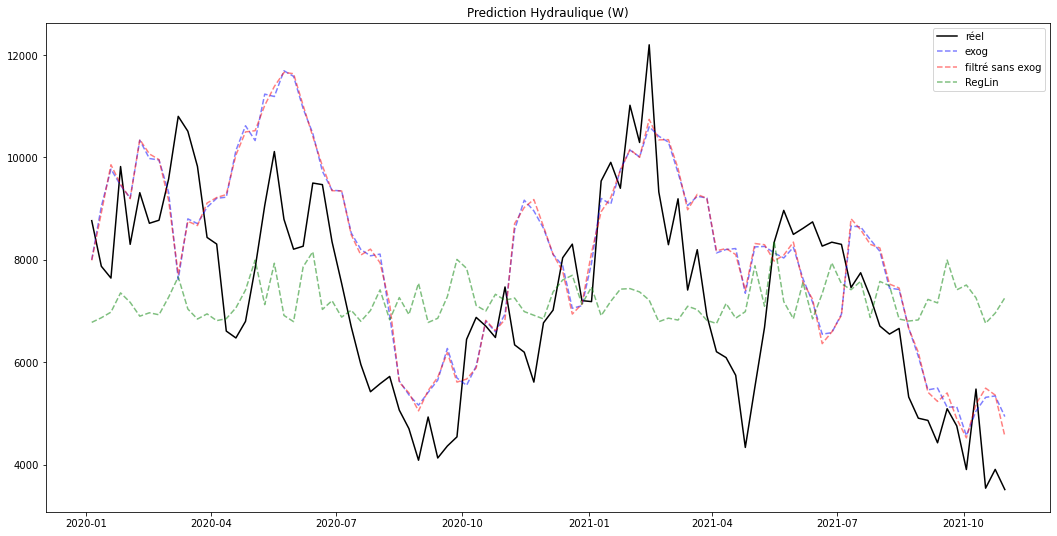

In [42]:
plt.figure(figsize=(18,9))
#plt.plot(df_train['Hydraulique'].resample('W').mean(), color = 'k')
plt.plot(bilan['Hydraulique'].resample('W').mean(), color = 'k', label = 'réel')
plt.plot(bilan['Hyd_p_exog'].resample('W').mean(), color = 'b', linestyle = '--', alpha = 0.5, label = 'exog')
plt.plot(bilan['Hyd_p_noreg'].resample('W').mean(), color = 'r', linestyle = '--', alpha = 0.5, label = 'filtré sans exog')
plt.plot(bilan['Hyd_p_LinReg'].resample('W').mean(), color = 'g', linestyle = '--', alpha = 0.5, label = 'RegLin')
plt.legend(loc = 'upper right')
plt.title('Prediction Hydraulique (W)')
plt.savefig('./results/W/pred_hydraulique_W.png');

# Synthèse des erreurs

In [43]:
erreur = bilan[['Err_exog',
       'Err_noreg',
       'Err_LinReg'
      ]].describe()
erreur

,Err_exog,Err_noreg,Err_LinReg
count,96.000000,96.000000,96.000000
mean,1372.188043,1381.289839,1572.717859
std,895.974260,891.881732,1096.619869
min,29.709580,65.720150,22.287363
25%,758.183261,755.333809,611.377875
50%,1159.469597,1122.072999,1458.756887
75%,1862.505891,1916.771573,2379.297881
max,3819.711112,3700.178123,4986.406959


In [44]:
bilan.to_csv('./results/W/bilan_hydraulique_W.csv', sep = ';')
erreur.to_csv('./results/W/erreur_hydraulique_W.csv', sep = ';')